In [1]:
#Import Functions
from pyspark.sql.functions import *
from datetime import datetime
from pyspark.sql.functions import to_date, to_timestamp
import math

In [2]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
dfStock = spark.read.format("csv").option("header", "true").load("/FileStore/tables/*.csv")
# dfStock.show()

In [4]:
dfNetflix = dfStock.select('*').where(dfStock.company == 'NETFLIX')
dfNetflix = dfNetflix.select('*').where(dfStock.stock_date == '101918')
dfNetflix1 = dfNetflix.toPandas()
dfNetflix2 = dfNetflix1.sort_values(['timestamp'])
dfNetflix3 = dfNetflix2[['close','timestamp']]
dfNetflix3['timestamp'] = pd.to_datetime(dfNetflix3['timestamp'])
dfNetflix3 = dfNetflix3.set_index('timestamp')

In [5]:
#Train test split
train = dfNetflix3[:int(0.8*(len(dfNetflix3)))]
test = dfNetflix3[int(0.8*(len(dfNetflix3))):]
# train.head(5)

In [6]:
train1 = spark.createDataFrame(train)
train2 = train1.select("close")
from pyspark.sql.types import IntegerType
train2 = train2.withColumn("close",train2["close"].cast("float"))
train3 = train2.toPandas()
ts = train3.close

In [7]:
test1 = spark.createDataFrame(test)
test2 = test1.select("close")
from pyspark.sql.types import IntegerType
test2 = test2.withColumn("close",test2["close"].cast("float"))
test3 = test2.toPandas()
ts_test = test3.close

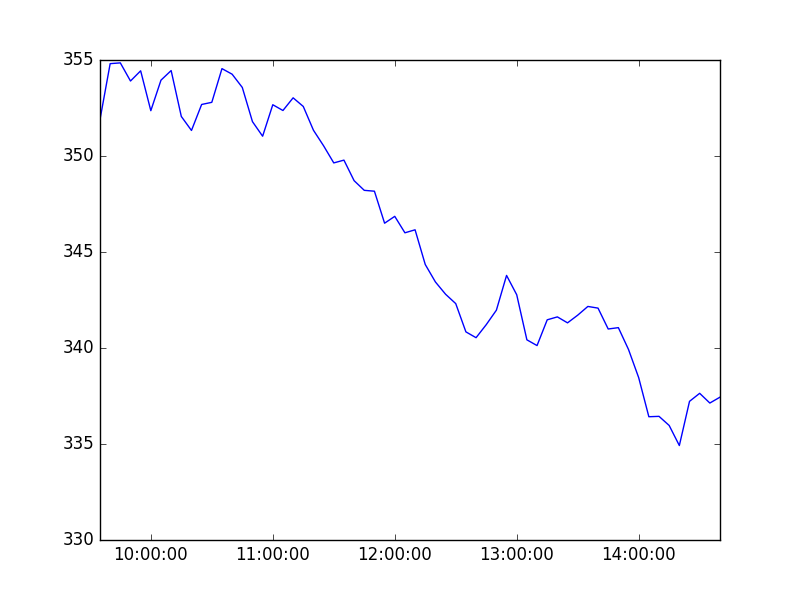

In [8]:
fig, ax = plt.subplots()
plt.plot(train.close)
display(fig)

In [9]:
def test_stationarity(df):    
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [10]:
test_stationarity(train3.close)

Test Statistic -0.327034
p-value 0.921587
#Lags Used 0.000000
Number of Observations Used 61.000000
Critical Value (5%) -2.910236
Critical Value (1%) -3.542413
Critical Value (10%) -2.592745
dtype: float64

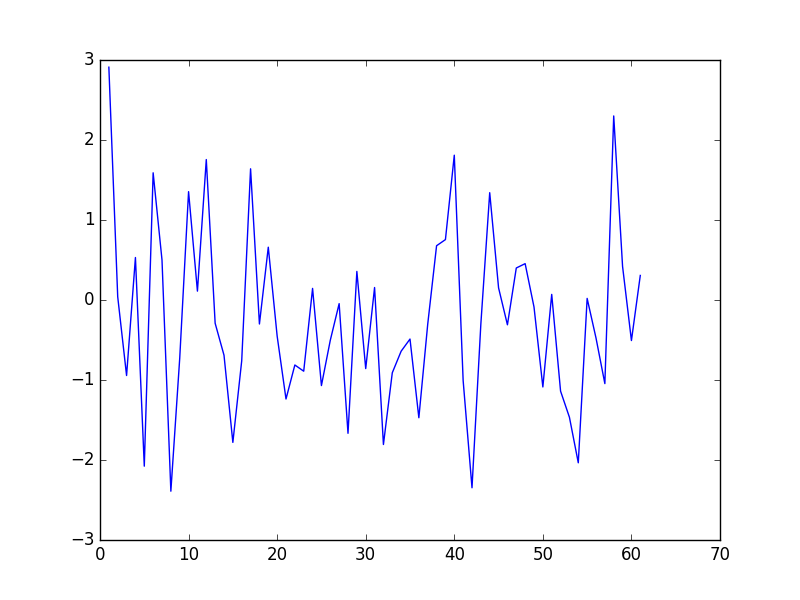

In [11]:
ts_diff = ts - ts.shift()
ts_diff.drop(ts_diff.index[0], inplace=True)
fig, ax = plt.subplots()
plt.plot(ts_diff)
display(fig)

In [12]:
test_stationarity(ts_diff)

Test Statistic -7.886078e+00
p-value 4.566046e-12
#Lags Used 0.000000e+00
Number of Observations Used 6.000000e+01
Critical Value (5%) -2.911073e+00
Critical Value (1%) -3.544369e+00
Critical Value (10%) -2.593190e+00
dtype: float64

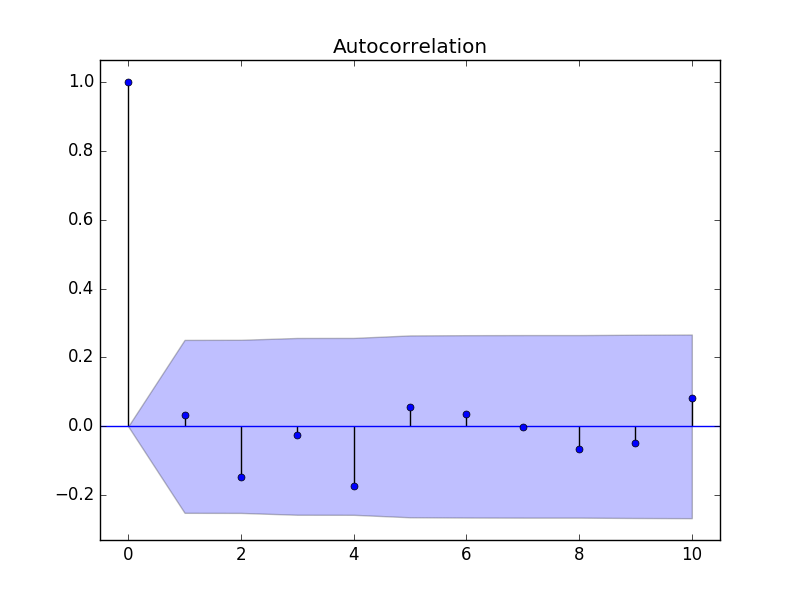

In [13]:
acf1 = plot_acf(ts_diff, lags=10)
display(acf1)

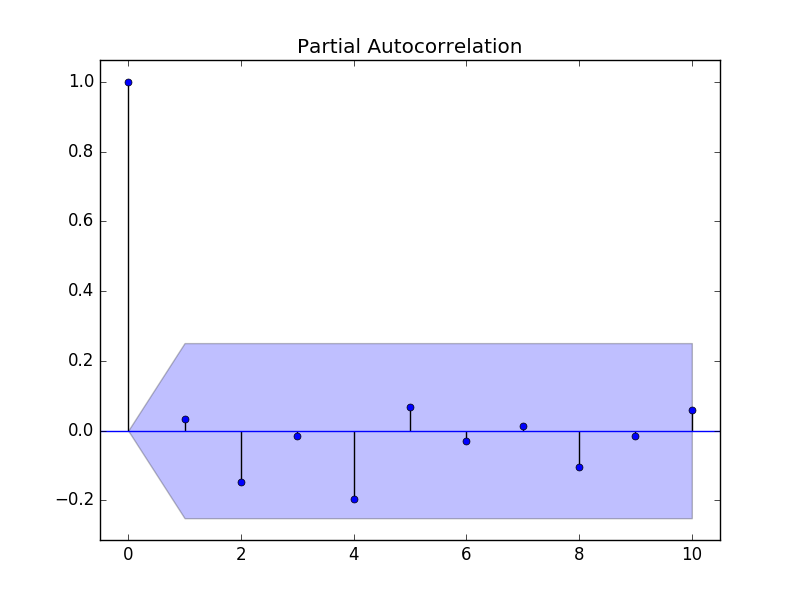

In [14]:
pacf1 = plot_pacf(ts_diff, lags=10)
display(pacf1)

In [15]:
model = ARIMA(ts_diff.values, order=(0, 1, 0)) 
results_ARIMA = model.fit(maxiter=10)  
print(results_ARIMA.summary())

ARIMA Model Results 
==============================================================================
Dep. Variable: D.y No. Observations: 60
Model: ARIMA(0, 1, 0) Log Likelihood -109.962
Method: css S.D. of innovations 1.512
Date: Thu, 13 Dec 2018 AIC 223.924
Time: 00:45:01 BIC 228.113
Sample: 1 HQIC 225.563
 
==============================================================================
 coef std err z P>|z| [95.0% Conf. Int.]
------------------------------------------------------------------------------
const -0.0434 0.195 -0.222 0.825 -0.426 0.339
==============================================================================

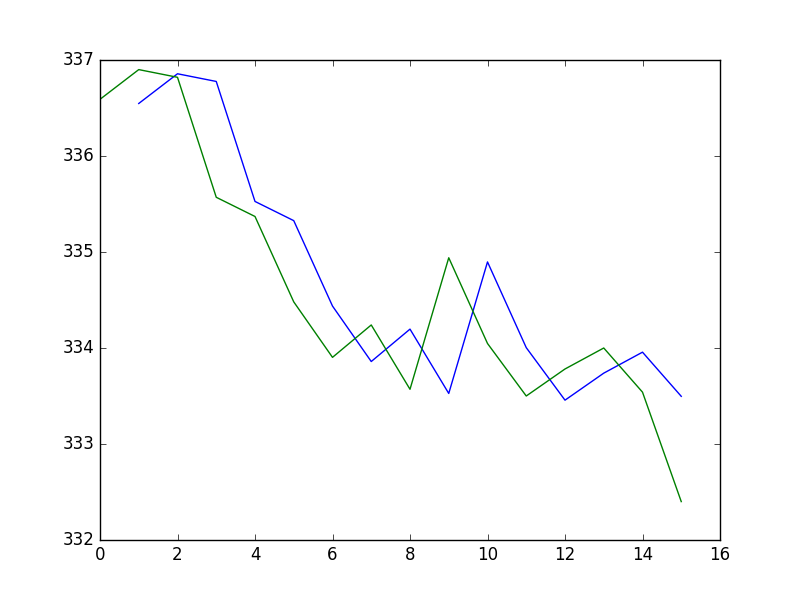

In [16]:
fitted_values  = results_ARIMA.predict(1,len(test3)-1,typ = "linear")
fitted_values1 = fitted_values + ts_test.shift()[1:]
fig, ax = plt.subplots()
plt.plot(fitted_values1)
plt.plot(ts_test)
display(fig)

In [17]:
train_test = pd.concat([train3,test3])
fitted_values1 = pd.DataFrame(fitted_values1)
df = pd.DataFrame([337],columns = ["close"])
train_fitted1 = pd.concat([train3,df, fitted_values1])
train_test = train_test.reset_index()
train_fitted1 = train_fitted1.reset_index()

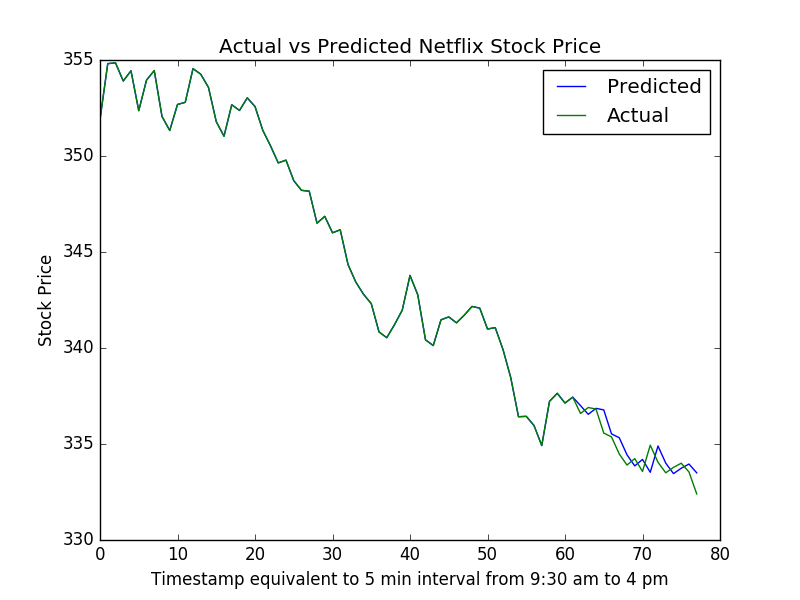

In [18]:
figure, ax = plt.subplots()
ax.plot(train_fitted1.close,label='Predicted')
ax.plot(train_test.close,label='Actual')
ax.set(title='Actual vs Predicted Netflix Stock Price', xlabel='Timestamp equivalent to 5 min interval from 9:30 am to 4 pm', ylabel='Stock Price')
legend = ax.legend(loc='upper right')
display(figure)